# Import and config
Using this cell to import all the necessary libraries

In [1]:
# %pip install matplotlib

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from pipeline.build_dataset import make_state_frame
from features.state_assembler import StateAssembler
from envs.buy_env import BuyEnv
from agents.buy_agent_trainer import BuyAgentTrainer


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Helper

In [3]:
import matplotlib.pyplot as plt

def plot_loss(agent):
    losses = agent.loss_history
    plt.figure(figsize=(10,5))
    plt.plot(losses, alpha=0.7)
    plt.title("DDQN Loss History (Buy Agent - Multiprocess Training)")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


# Load config and data

In [4]:
cfg = yaml.safe_load(open("config/data_config.yaml"))

ticker = "AAPL"
dataset = make_state_frame(ticker, cfg)
print("Raw dataset shape:", dataset.shape)
print(dataset.tail())

[*********************100%***********************]  1 of 1 completed

Raw dataset shape: (1224, 10)
            return_1d     rsi14  macd_diff      bb_b     atr14     roc10  \
Date                                                                       
2023-12-22  -0.182760  0.089441  -0.627491 -0.178011 -1.820037 -0.282915   
2023-12-26  -0.538529 -0.175613  -0.849465 -0.533543 -1.984080 -0.573011   
2023-12-27  -0.341273 -0.314185  -1.030831 -0.759737 -2.209548 -0.357039   
2023-12-28  -0.084730 -0.299805  -1.123311 -0.790066 -2.209548 -0.531210   
2023-12-29   0.041508 -0.208808  -1.127637 -0.746857 -2.209548 -0.867670   

                 obv     mfi14   willr14       price  
Date                                                  
2023-12-22  1.349133 -0.061185 -0.080586  191.788773  
2023-12-26  1.259801 -0.044919 -0.988172  191.243912  
2023-12-27  1.190502 -0.392735 -1.621948  191.342972  
2023-12-28  1.300912 -0.723739 -1.453427  191.768951  
2023-12-29  1.382170 -0.785871 -1.292256  190.728790  


# Building rolling states

In [5]:
feature_cols = [c for c in dataset.columns if c != "price"]
assembler = StateAssembler(feature_cols=feature_cols, window_size=30)

state_df = assembler.assemble(dataset)
prices = dataset["price"].iloc[30:]  # align with state_df

print("state_df shape:", state_df.shape)
print("prices shape:", prices.shape)
print("NaNs in state_df:", state_df.isna().sum().sum())
print("NaNs in prices:", prices.isna().sum())


state_df shape: (1194, 270)
prices shape: (1194,)
NaNs in state_df: 0
NaNs in prices: 0


# Train DDQN Buy Agent

[*********************100%***********************]  1 of 1 completed


[BuyTrainer] Raw dataset: (1224, 10)
[BuyTrainer] After dropna: (1224, 10)
[BuyTrainer] Rolling state_df shape: (1194, 270)
[BuyTrainer] state_dim=270, actions=2
[BuyTrainer-MP] Starting multi-process training: 4 workers, 300 batches, 300 steps/batch, 40 updates/batch
[MP Trainer] Starting workers...


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


[Batch 10/300] Buffer size = 3000
[Batch 20/300] Buffer size = 6000
[Batch 30/300] Buffer size = 9000
[Batch 40/300] Buffer size = 12000
[Batch 50/300] Buffer size = 15000
[Batch 60/300] Buffer size = 18000
[Batch 70/300] Buffer size = 21000
[Batch 80/300] Buffer size = 24000
[Batch 90/300] Buffer size = 27000
[Batch 100/300] Buffer size = 30000
[Batch 110/300] Buffer size = 33000
[Batch 120/300] Buffer size = 36000
[Batch 130/300] Buffer size = 39000
[Batch 140/300] Buffer size = 42000
[Batch 150/300] Buffer size = 45000
[Batch 160/300] Buffer size = 48000
[Batch 170/300] Buffer size = 51000
[Batch 180/300] Buffer size = 54000
[Batch 190/300] Buffer size = 57000
[Batch 200/300] Buffer size = 60000
[Batch 210/300] Buffer size = 63000
[Batch 220/300] Buffer size = 66000
[Batch 230/300] Buffer size = 69000
[Batch 240/300] Buffer size = 72000
[Batch 250/300] Buffer size = 75000
[Batch 260/300] Buffer size = 78000
[Batch 270/300] Buffer size = 81000
[Batch 280/300] Buffer size = 84000
[Bat

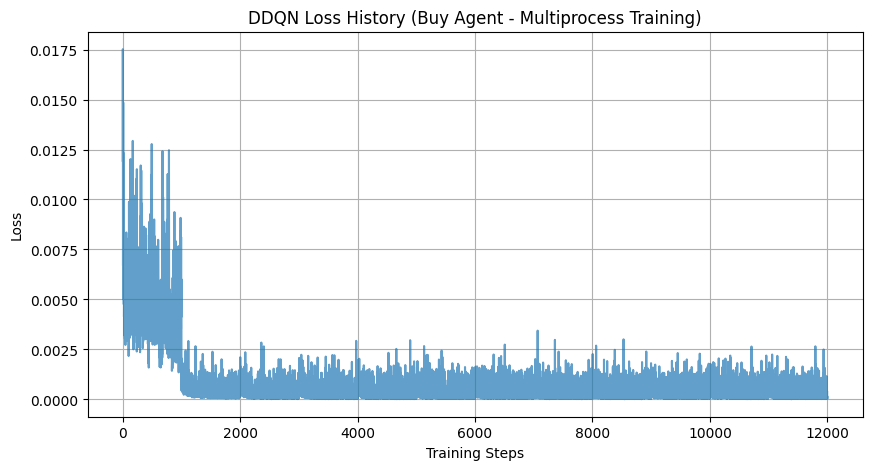

In [6]:
# trainer = BuyAgentTrainer(
#         cfg_path="config/data_config.yaml",
#         ticker="AAPL",
#         window_size=30,
#         horizon=5,
#         transaction_cost=0.001,
#     )

# print("Last 10 episode rewards:", rewards[-10:])
# history = trainer.train(n_episodes=50)
buy_trainer = BuyAgentTrainer(
    ticker="AAPL",
    window_size=30,
    horizon=20,
    transaction_cost=0.001,
    lambda_dd=0.05,
    lambda_vol=0.01,
    hold_penalty_long=0.0,
    device="cpu",
)

# Multi-process training
buy_trainer.train_multiprocess(
    n_batches=300,
    updates_per_batch=40,
    n_workers=4,
    steps_per_batch=300,
)

plot_loss(buy_trainer.agent)


# import pandas as pd
# df = pd.DataFrame(history)
# print(df.head())


# greedy_policy = trainer.make_greedy_policy()
# total_reward, steps = greedy_policy()
# print(f"Greedy run: total_reward={total_reward:.4f}, steps={steps}")

# Plot training reward curve

In [7]:
# plt.figure(figsize=(12,5))
# plt.plot(rewards, label="Episode Reward", marker="o")
# plt.title("DDQN Buy Agent – Training Reward Curve")
# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.grid(True)
# plt.legend()
# plt.show()
# plot_training_report(history)
policy = buy_trainer.make_greedy_policy()
total_reward, steps = policy()

print("Greedy evaluation:")
print("Reward:", total_reward)
print("Steps:", steps)



Greedy evaluation:
Reward: -0.024941522759270113
Steps: 1193


In [ ]:
rewards = []
for _ in range(20):
    r, s = policy()
    rewards.append(r)

plt.figure(figsize=(10,5))
plt.plot(rewards, marker="o")
plt.title("Greedy Policy Rewards (Buy Agent after MP Training)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

print("Mean:", sum(rewards)/len(rewards))


# Buy signal

In [8]:
# # Get environment price series
# prices = trainer.prices.copy()
# index = prices.index

# # Re-run greedy to get signal points
# env = trainer.env
# state = env.reset()
# done = False
# buy_index = None

# while not done:
#     a = trainer.agent.select_action(state, greedy=True)
#     if a == 1:   # BUY
#         buy_index = env.idx
#     state, r, done, info = env.step(a)

# plt.figure(figsize=(13,5))
# plt.plot(prices.values, label="Price", color="black")
# if buy_index is not None:
#     plt.scatter([buy_index], [prices.iloc[buy_index]], s=120, color="green", label="BUY", marker="^")
# plt.title("Greedy Policy – BUY Decision on Price Series")
# plt.xlabel("Index")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.show()


# Loss history

In [9]:
# plt.figure(figsize=(10,4))
# plt.plot(trainer.agent.loss_history)
# plt.title("DDQN Loss Curve")
# plt.xlabel("Training Step")
# plt.ylabel("Loss")
# plt.show()


# Inspecting one simple state

In [10]:
# sample = trainer.state_df.iloc[0]
# print("Example state vector:", sample.values[:20], "... (total length:", len(sample), ")")
